In [24]:
#We can go into our root file and see what Trees are availiable
%matplotlib inline
import sys, os
if __package__ is None:
    import sys, os
    sys.path.append(os.path.realpath("/data/shared/Software/"))
    sys.path.append(os.path.realpath("../../"))
import numpy as np
import pandas as pd
import ntpath
import glob
import deepconfig

from CMS_Deep_Learning.utils.metrics import plot_history, print_accuracy_m
from CMS_Deep_Learning.utils.callbacks import OverfitStopping, SmartCheckpoint

from keras.models import Sequential
from keras.layers import Dense, Flatten, Reshape, Activation, Dropout, Convolution2D
from keras.callbacks import EarlyStopping


dc = deepconfig.deepconfig(gpu='gpu1', backend='theano')

#The observables taken from the table
observ_types = ['E/c', 'Px', 'Py', 'Pz', 'PID', 'Charge', "PT", "Eta", "Phi"]
set_size = 20
vecsize = len(observ_types)
epochs = 100
batch_size = 100

#http://pdg.lbl.gov/2012/reviews/rpp2012-rev-monte-carlo-numbering.pdf
observable_vocab = [0,-11,11,15,-15,-13,13,22]
quark_vocab = [5,-5,6,-6]
neutrino_vocab = [12,-12, 14, -14, 16, -16, 18, -18]
unobservable_boson_vocab = [24, -24]
jet_vocab = [100, -100]
missing_ET_vocab = [83,84]

particle_vocab = observable_vocab + neutrino_vocab + quark_vocab +  unobservable_boson_vocab + jet_vocab + missing_ET_vocab
particle_dict = {particle_vocab[i]:i for i in range(len(particle_vocab))}
#print(particle_dict)
def cullNonObservables(frame):
    #Status of 1 means that the particle is a stable product
    stable_cond = frame["Status"] == 1 
    #All even leptons are neutrinos which we can't measure
    notNeutrino_cond = ((np.abs(frame["PID"]) != 12) & (np.abs(frame["PID"]) != 14) & (np.abs(frame["PID"]) != 16)) 
    #Get all entries that satisfy the conditions
    frame = frame[stable_cond & notNeutrino_cond]
    #Drop the Status frame since we only needed it to see if the particle was stable
    frame = frame.drop(["Status"], axis=1)
    return frame

def mapPIDS(observables):
    PIDS = observables["PID"] 
    observables["PID"] = PIDS.apply(lambda x: particle_dict[x])

def padItem(x, shuffle=False):
    if(len(x) > set_size):
        return x[:set_size]
    else:
        out = np.append(x ,np.array(np.zeros((set_size - len(x), vecsize))), axis=0)
        if(shuffle): np.random.shuffle(out)
        return out
def padInput(l,shuffle=False):
    out = []
    for x in l:
        out.append(padItem(x, shuffle=shuffle))
    return out

def helper_gETA(x, arr):
    arr.append(np.array(x))
    return 0
def groupEntriesToArrays(frame, select):
    arr = []
    grouped = frame.groupby(["Entry"])[select].apply(lambda x: helper_gETA(x,arr))
    return arr
def preprocessFromPandas_file_label_pairs(files, cull=False):
    X_train = []
    y_train = []
    X_train_by_label = {}
    y_train_by_label = {}
    for f,label in files:
        all_particles = pd.read_hdf(f, 'data')
        if(cull):
            observables = cullNonObservables(all_particles)
        else:
            observables = all_particles
        #print(observables)
        cond = np.abs(observables["Entry"]) < 5
        frame_cond = observables[cond].sort(["Entry"])
        print(label, f)
        print(frame_cond)
        
        mapPIDS(observables)
        processedInput = padInput(groupEntriesToArrays(observables, observ_types))
       
        X_train_by_label[label] = X_train_by_label.get(label, []) + processedInput
        y_train_by_label[label] = y_train_by_label.get(label, []) + ([label] * len(processedInput))
    
    #Truncate the data so that we have the same amount in each catagory
    minimumN = min([len(X_train_by_label[label]) for label in X_train_by_label])
    for label in X_train_by_label:
        X_train = X_train + X_train_by_label[label][:minimumN]
        y_train = y_train + y_train_by_label[label][:minimumN]
    X_train_by_label = None
    y_train_by_label = None
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    indices = np.arange(len(y_train))
    np.random.shuffle(indices)
    X_train = X_train[indices]
    y_train = y_train[indices]
   
    return X_train, y_train



using gpu1
using theano


In [25]:
nFiles = 10
ttbar_files = glob.glob("/data/shared/Delphes/ttbar_13TeV/parsed_pandas/*.h5")
WJet_files = glob.glob("/data/shared/Delphes/WJets_13TeV/parsed_pandas/*.h5")
files = []
for i in range(nFiles):
    files.append((ttbar_files[i],0))
    files.append((WJet_files[i],1))



In [ ]:
X_train, y_train = preprocessFromPandas_file_label_pairs(files, cull=True)

(0, '/data/shared/Delphes/ttbar_13TeV/parsed_pandas/ttbar_13TeV_80.h5')
     Entry          E/c          Px          Py           Pz  PID  Charge  \
0        0    15.772708   -3.238023  -13.761521     6.993857   22       0   
0        0   255.885448  -12.168896    1.156054  -255.593318   84       0   
4        0    30.105108  -22.559323    0.252790    19.643099 -100      -1   
0        0   431.561162   24.542967    6.794588   430.809138   83       0   
3        0    62.877428  -43.257067  -18.736153   -41.343790  100       1   
2        0   155.441623  100.694310   25.011148   114.732764  100       1   
1        0   122.698499   -5.560530  105.674392    61.277102  100       1   
0        0   150.681955  -28.866792 -130.453925    68.552655  100       1   
58       1    26.241314  -12.902191  -18.211334    13.801711   11      -1   
8        1    27.399367  -13.471578  -19.015018    14.410794  100       1   
7        1   306.220026   32.241937   13.512181  -304.160004  100       1   
6   

In [ ]:
histories = {}
cull=False
add_title = "_AllParticles"
cull=True
add_title = "_ObservableOnly"
for i in range (1):
   
    X_train, y_train = preprocessFromPandas_file_label_pairs(files, cull=cull)
    X_train_flatten = np.array([np.ndarray.flatten(x) for x in X_train])
    #DENSE
    dense = Sequential()
    dense.add(Dense(10, input_dim=set_size * vecsize,activation='relu'))
    #model.add(Dropout(.5))
    dense.add(Dense(1, activation='sigmoid'))
    dense.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    #CONVOLUTIONAL
    conv = Sequential()
    conv.add(Convolution2D(40,4,4, input_shape=(1,set_size,vecsize),activation='relu'))
    conv.add(Flatten())
    conv.add(Dense(1, activation='sigmoid'))
    conv.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    earlyStopping = EarlyStopping(verbose=1, patience=10)
    overfitStopping = OverfitStopping(verbose=1, patience=10)
    smartCheckpoint = SmartCheckpoint("dense"+add_title)
    #RUN Dense
    dense_history = dense.fit(X_train_flatten, y_train,
                        batch_size=batch_size,
                        nb_epoch=epochs,
                        validation_split=.2,
                        callbacks=[earlyStopping, overfitStopping])
    histories["dense"+add_title] = (dense,dense_history,X_train_flatten, y_train)
#   plot_history([("dense",dense_history)])

    
    earlyStopping = EarlyStopping(verbose=1, patience=10)
    overfitStopping = OverfitStopping(verbose=1, patience=10)
    #Run Conv
    conv_history = conv.fit(np.reshape(X_train, (len(X_train), 1, set_size, vecsize)), y_train,
                        batch_size=batch_size,
                        nb_epoch=epochs,
                        validation_split=.2,
                        callbacks=[earlyStopping, overfitStopping])
    #plot_history([("conv",conv_history)])
    histories["conv"+add_title] = (conv,conv_history,X_train, y_train)
    add_title = "_ObservableOnly"
    cull=True

(0, '/data/shared/Delphes/ttbar_13TeV/parsed_pandas/ttbar_13TeV_80.h5')
     Entry          E/c          Px          Py           Pz  PID  Charge  \
0        0    15.772708   -3.238023  -13.761521     6.993857   22       0   
0        0   255.885448  -12.168896    1.156054  -255.593318   84       0   
4        0    30.105108  -22.559323    0.252790    19.643099 -100      -1   
0        0   431.561162   24.542967    6.794588   430.809138   83       0   
3        0    62.877428  -43.257067  -18.736153   -41.343790  100       1   
2        0   155.441623  100.694310   25.011148   114.732764  100       1   
1        0   122.698499   -5.560530  105.674392    61.277102  100       1   
0        0   150.681955  -28.866792 -130.453925    68.552655  100       1   
58       1    26.241314  -12.902191  -18.211334    13.801711   11      -1   
8        1    27.399367  -13.471578  -19.015018    14.410794  100       1   
7        1   306.220026   32.241937   13.512181  -304.160004  100       1   
6   

In [32]:
keys = [key for key in histories]
def p(key):
    tup = histories[key]
    model = tup[0]
    history = tup[1]
    #print_accuracy_m(model, tup[2], tup[3])
    print(key + ': Best Validation accuracy: %r%%' % max(history.history["val_acc"]))
    plot_history([(key, history)])


dense_ObservableOnly: Best Validation accuracy: 0.99365950917129275%


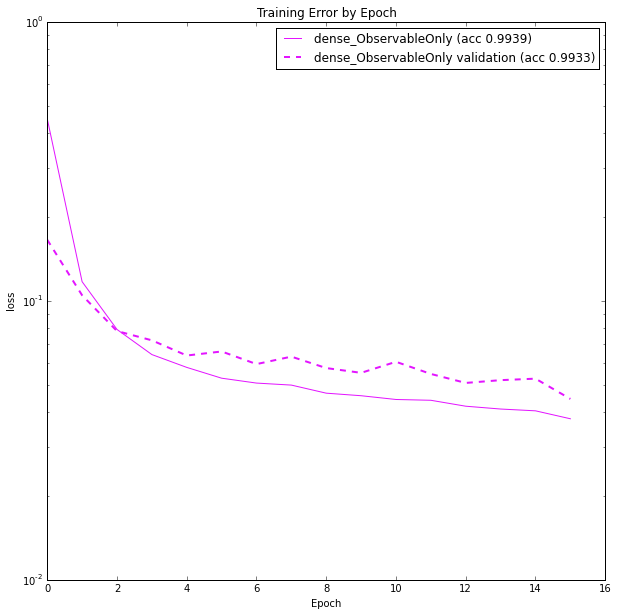

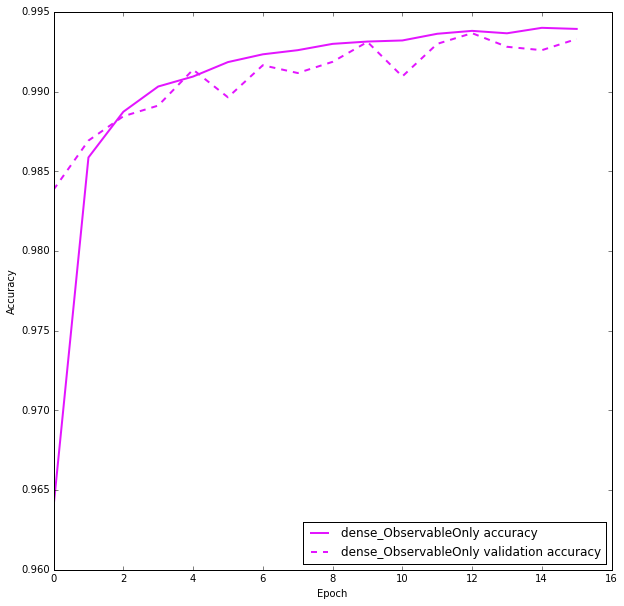

In [33]:
p(keys[0])

conv_ObservableOnly: Best Validation accuracy: 0.9947569016330291%


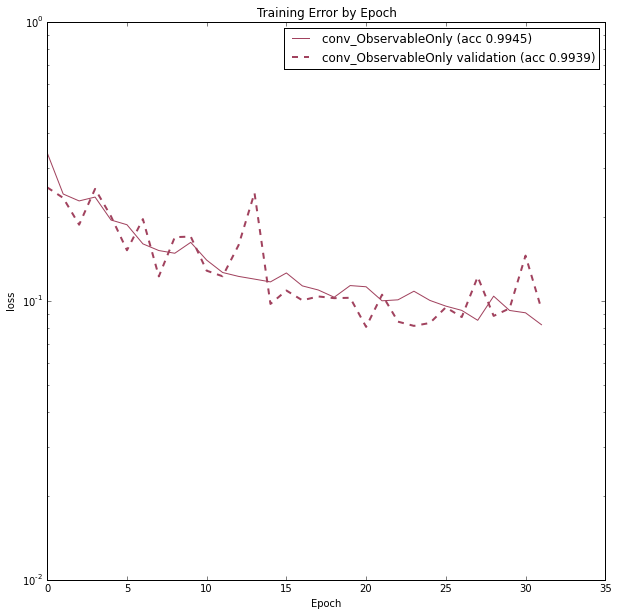

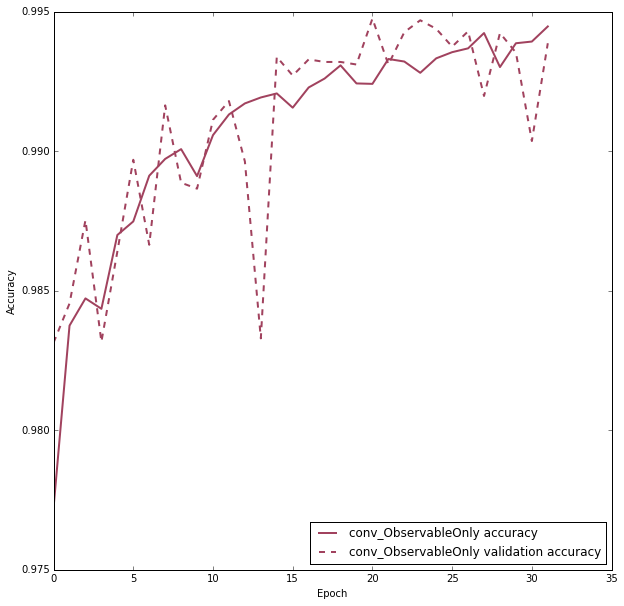

In [34]:
p(keys[1])

In [35]:
p(keys[2])

IndexError: list index out of range

In [ ]:
p(keys[3])